### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

### Loading the data

In [4]:
official_names = ['Benzyl_benzoate', 'm Anisaldehyde']

In [5]:
os.getcwd()

'/home/basia/Documents/spectroscopy/magnetstein_data/experiment_3_overlapping_and_intensity_difference'

In [6]:
mix = np.loadtxt(os.getcwd()+'/m_anisaldehyde_benzylbenzoate_nakrywajace_sie_I_dyzy_zakres+intensywnosci_pikow.csv', skiprows=0, usecols=range(2), 
                      delimiter='\t',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library.csv', skiprows=1, usecols=[0, 2, 4],
                      delimiter='\t',dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [7]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [8]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [9]:
mix = Spectrum(confs=list(zip(ppm,mix)))

In [10]:
# mix.plot(profile=True)
# spectra[0].plot(profile=True)
# spectra[1].plot(profile=True)

### Ground truth

In [11]:
protons = [12, 8]
mass_proportions = [0.8914, 0.1086]
molar_masses = [212.25, 136.15]

In [12]:
molar_proportions = [mass_prop/mol_mass for mass_prop, mol_mass in zip(mass_proportions, molar_masses)]
molar_proportions = [mol_prop/sum(molar_proportions) for mol_prop in molar_proportions]

In [13]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]

In [14]:
real_visible_proportions

[0.8876121810260892, 0.1123878189739109]

In [15]:
mass_proportions

[0.8914, 0.1086]

### Preprocessing

In [16]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [17]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [18]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [19]:
spectra_and_mixture = spectra + [mix]

In [20]:
spectra_and_mixture = shift(spectra_and_mixture)

In [21]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [22]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [23]:
cma = common_mass_axis(spectra_and_mixture)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [25]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [26]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [27]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [28]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [29]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [30]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


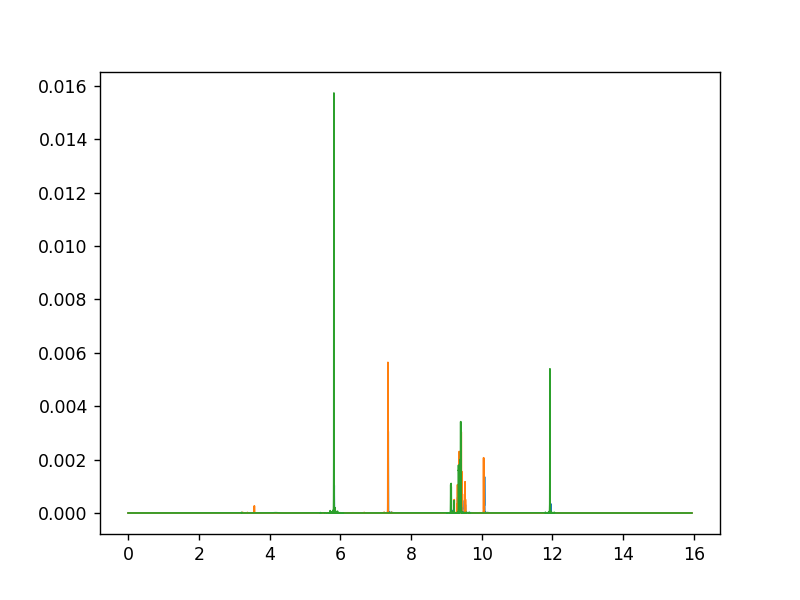

In [31]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Estimation

In [32]:
estimation = estimate_proportions(mix, spectra, 
                                   MTD=0.2, MTD_th=0.2, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 56.84it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.0009999999999998899, 15.94445, 0), (0.0009999999999998899, 15.94445, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-0.19900000000000012, 16.14445)]


Splitting the experimental spectrum into chunks: 131072it [00:00, 2870412.81it/s]


Ion currents in chunks: [1.0000000000000153]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 524287 rows, 131075 columns and 1254637 nonzeros
Model fingerprint: 0x4ab613e2
Coefficient statistics:
  Matrix range     [4e-12, 1e+00]
  Objective range  [4e-12, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 2e-01]
Presolve removed 15391 rows and 0 columns (presolve time = 5s) ...
Presolve removed 39167 rows and 0 columns (presolve time = 10s) ...
Presolve removed 154128 rows and 0 columns
Presolve time: 83.22s
Presolved: 131075 rows, 524286 columns, 1254636 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3

Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.87s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.962105900836
Noise proportion in experimental spectrum: 0.037894099163000045
Total explanation: 0.999999999999
Noise proportion in combination of theoretical spectra: 0.022485676956


In [33]:
estimation['proportion_of_noise_in_theoretical']

0.022485676956000344

In [34]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.8552251068440131, 0.10688079399200164]

In [35]:
estimated_molar_proportions = [estimated_visible_proportions[0]/16, estimated_visible_proportions[1]/12]
estimated_molar_proportions = [mp/sum(estimated_molar_proportions) for mp in estimated_molar_proportions]

In [36]:
estimated_mass_proportions = [mol_mass*est_mol_prop 
                              for mol_mass, est_mol_prop in zip(molar_masses, estimated_molar_proportions)]
estimated_mass_proportions = [mp/sum(estimated_mass_proportions) for mp in estimated_mass_proportions]
estimated_mass_proportions

[0.9034339796259886, 0.09656602037401149]

In [37]:
mass_proportions

[0.8914, 0.1086]

In [38]:
real_visible_proportions

[0.8876121810260892, 0.1123878189739109]

### Visualisation of our estimation

In [39]:
p = estimated_visible_proportions

In [40]:
p = np.array(p).reshape(len(p),1)

In [41]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [46]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [47]:
X = np.concatenate(components_ints, axis=1)

In [48]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


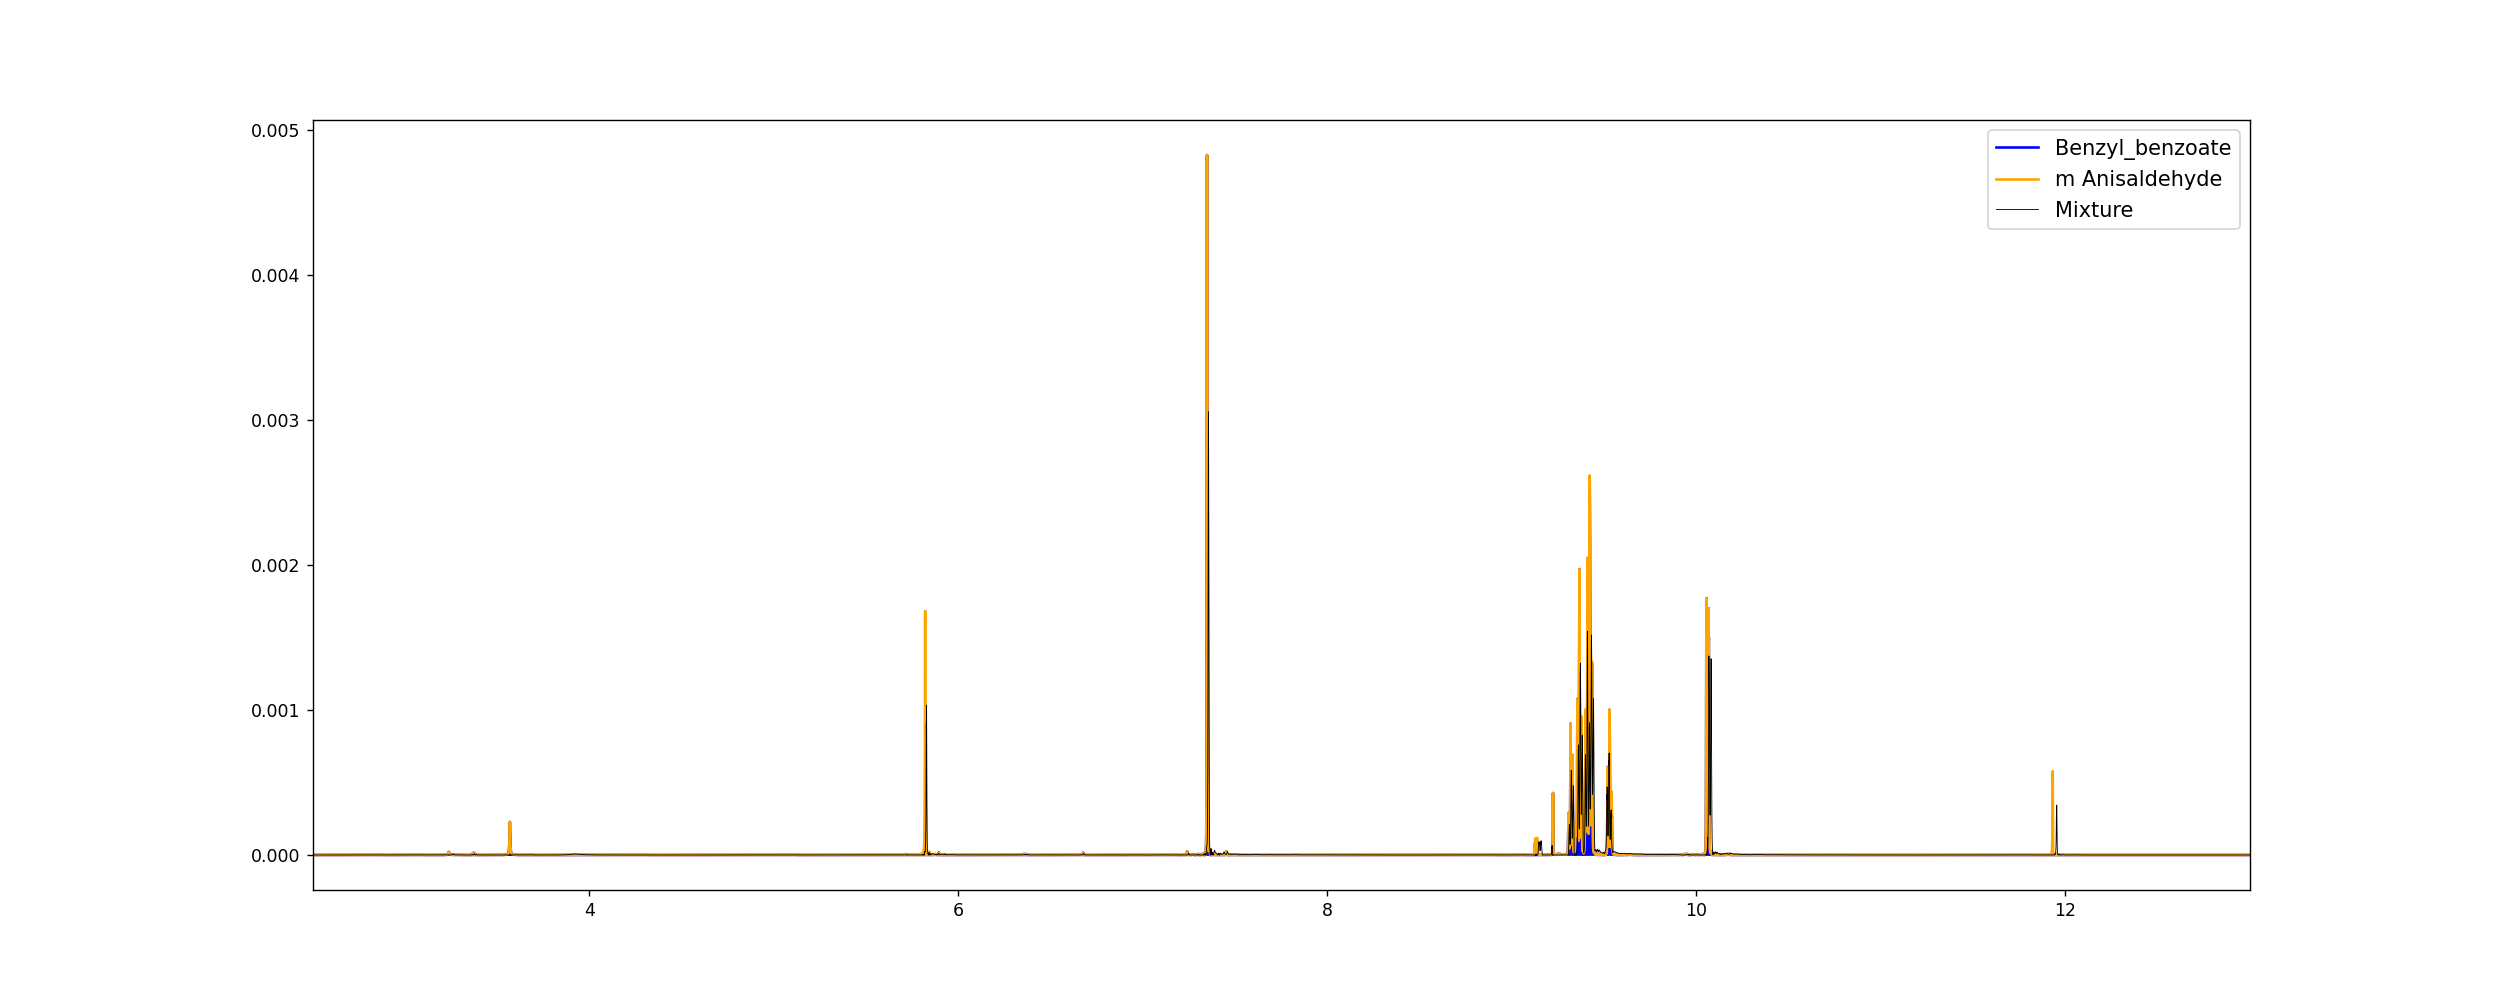

In [53]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(20, 8, forward=True)
ax.set_xlim(2.5, 13)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})

